# Reducing risk in drug development by incorporating gene-disease association data
___

## Introduction

Over the last few decades, pharmaceutical companies have used sophisticated biochemical synthesis techniques to generate an uncountable number of drug candidates. It is now in the initial steps of drug discovery where the greatest challenges are found. Before synthesis and testing of drug candidates, the relevant disease-causing molecular targets within the body must be identified. Fortunately, new tools in the form of genomic analyses are now gaining widespread acceptance and have the potential to dramatically improve progress in this area. 

A common molecular mechanism underlines many non-communicable diseases. In the body, genes carry information that dictate the structure and amount of proteins that must be synthesized for proper biological function. Environmental or hereditary factors can causes errors in gene encoding that lead to undesirable changes in protein synthesis. The constituents of these protein synthesis pathways represent the "molecular targets" drug researchers are seeking. By identifying the appropriate malfunctioning protein pathway, an effective drug therapy can be developed. 

Because of recent technological advancements in genomics, a multitude of publicly-available databases now exist that describe in detail the link between genes, molecular targets, and disease. Unfortunately this information is organized in non-standard formats and accessed through file downloads, web APIs, or form-based queries making it difficult for drug researchers to utilize these resources. Furthermore, once a target is identified there is still critical research on the business-side that needs to be performed in order to ensure profitability of the fully-developed pharmaceutical.

For these reasons I propose a project that will mate business and technical risk analysis and assist pharmaceutical companies in selecting drug development strategies that maximize the return on their R&D investment. In the first phase, I plan to compile all available gene-disease data into a central repository and develop an appropriate metric to identify the strongest gene-diseases links. In the second phase, I will search public health databases to find the rates of incidence for a long list of common and rare diseases and estimate market values. In the final phase, I will combine these two analyses to develop a list of gene targets and disease areas ranked by highest likelihood of achieving financial and technical success.

This data-based approach has an important advantage over traditional laboratory methods for drug discovery. Analyzing human genetics data bypasses a time-consuming and costly cell culture and animal preclinical experiments. In addition, verified gene-disease associations provide researchers with <i>a priori</i> information indicating that addressing a specific drug target will prove effective at treating the disease, thus reducing the risk of wasted R&D efforts.

___
## Overview of gene-disease association data
This example data comes from a single database (DisGeNET): http://www.disgenet.org/web/DisGeNET/menu/home

The weighted scores described below represent a metric [0,1] that describes the quality of the established link between the identified gene and associated diseases. Each gene may influence several diseases and each diseases may be influenced by several genes. 

<i>Score = ( WUniProt + WCTDhuman + WClinVar ) + ( WRat + WMouse ) + ( WGAD + WLHGDN + WBeFree )</i>

where <i>WUniProt = 0 or 0.3, WCTDhuman = 0 or 0.3, WRat = 0 or 0.1, WMouse = 0 or 0.1, WLiterature = WGAD or WLHGDN or WBeFree and WLiterature = 0.06 for LHGDN or BeFree, and WLiterature = 0.08 for GAD</i>. If the number of publications reporting a gene-disease association in the source database (<i>n<sub>gd</sub></i>) multiplied by 100 and divided by the number of publications in the source (<i>NLiterature</i>) is less than this quotient then <i> WLiterature = (n<sub>gd</sub> * 100) / NLiterature</i> is reported instead.

In the database I intend to construct, the number of diseases linked to a particular gene will influence the gene's 'drug development score'.

There are dozens of similar independently constructed databases that will need to be scraped or downloaded.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

In [2]:
file = 'all_gene_disease_associations.txt.gz'

# Roll through gzip csv file using pandas reader
reader = pd.read_csv(file, sep='\t', compression='gzip', iterator=True, chunksize=10000)

# Concatenate to build dataframe
df = pd.concat(reader, ignore_index=True)

In [3]:
# Inspect first and last 3 entries
dfview = pd.concat((df[:3],df[-3:]),axis=0,ignore_index=True)
dfview

,geneId,geneSymbol,geneName,diseaseId,diseaseName,score,NumberOfPubmeds,associationType,source
0,540,ATP7B,"ATPase, Cu++ transporting, beta polypeptide",umls:C0019202,Hepatolenticular Degeneration,0.972607,200,"AlteredExpression, Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, LHGDN, MGD, R..."
1,4160,MC4R,melanocortin 4 receptor,umls:C0028754,Obesity,0.940000,264,"Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, MGD, RGD, UNI..."
2,3667,IRS1,insulin receptor substrate 1,umls:C0011860,"Diabetes Mellitus, Type 2",0.907216,112,"Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, MGD, RGD, UNI..."
3,3690,ITGB3,"integrin, beta 3 (platelet glycoprotein IIIa, ...",umls:C0751711,Anterior ischemic optic neuropathy,0.000284,1,Biomarker,BeFree
4,4524,MTHFR,methylenetetrahydrofolate reductase (NAD(P)H),umls:C0751711,Anterior ischemic optic neuropathy,0.000284,1,Biomarker,BeFree
5,161882,ZFPM1,"zinc finger protein, FOG family member 1",umls:C1845837,Dyserythropoietic Anemia with Thrombocytopenia,0.000284,1,GeneticVariation,BeFree


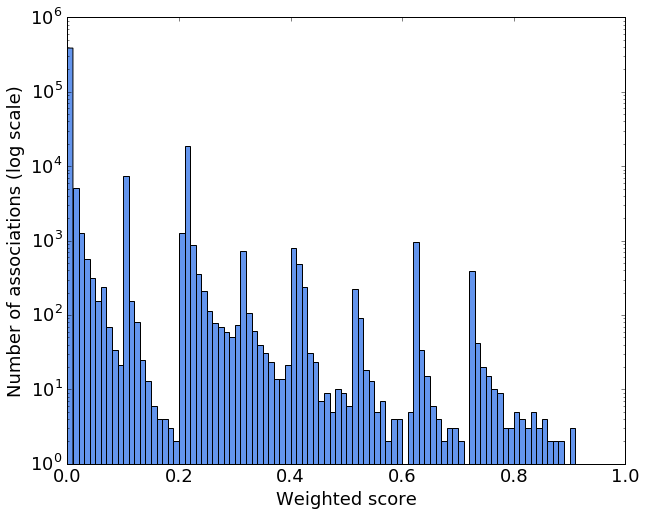

In [4]:
# Visualize distribution of scores among the gene-disease associations listed

bins = np.arange(0,1.01,0.01)
color = 'CornflowerBlue'


plt.rc('font', size='18')
# plt.ioff()

fig, ax = plt.subplots(1, figsize=(10,8))
ax.set_xlabel('Weighted score')
ax.set_ylabel('Number of associations (log scale)')
ax.set_yscale("log", nonposy='clip')
_,_,_ = plt.hist(df['score'], bins=bins, color=color)

plt.show()

### Notes

The data is heavily skewed toward the lower scores with median well below the mean and the majority of values below the midpoint of the score range.

Thus the population of scores near the top of the range is low, indicating a very small percentage of scores suggest a strong gene-disease link.

In [5]:
# Mean and median score of all disease

print('Mean score:', '{:.5f}'.format(df['score'].mean()))
print('Median score:', '{:.5f}'.format(df['score'].median()))

sermid = df['score']>0.5   # return boolean series so sum to get count of True values
print('Percentage of data above score range midpoint (0.5):', '{:.2%}'.format(sermid.sum()/df['score'].count()))

Mean score: 0.01932
Median score: 0.00057
Percentage of data above score range midpoint (0.5): 0.45%


### Refine data

Express data in terms of number of genes per disease and score for each association.

Diseases with higher scores and fewer genes are ideal.

In [6]:
# Number of genes per disease
dfdis = df[['diseaseName','geneSymbol']].groupby(['diseaseName'], sort=False).count()
dfdis.columns = ['Number of genes']
dfdis.sort_values('Number of genes', ascending=False, inplace=True)

print('Number of total diseases in database:', dfdis.shape[0])

# Move diseaseName to column and reset index to integers
dfdis.reset_index(level=0, inplace=True)
dfdis.head()

Number of total diseases in database: 14586


,diseaseName,Number of genes
0,"NEOPLASM, MALIGNANT",5689
1,Primary malignant neoplasm,5095
2,Malignant neoplasm breast,4219
3,Breast Carcinoma,3983
4,Carcinogenesis,3398


In [7]:
# Select desired data from dataframe to be combined with new data giving number of genes per disease
# Also drop duplicates
# dfscore = df[['diseaseName','score','geneName']].drop_duplicates('diseaseName').set_index('diseaseName')

dfscore = df[['diseaseName','score','geneSymbol','geneName']]

print(dfscore.shape)
dfscore.head()

(429111, 4)


,diseaseName,score,geneSymbol,geneName
0,Hepatolenticular Degeneration,0.972607,ATP7B,"ATPase, Cu++ transporting, beta polypeptide"
1,Obesity,0.940000,MC4R,melanocortin 4 receptor
2,"Diabetes Mellitus, Type 2",0.907216,IRS1,insulin receptor substrate 1
3,Rett Syndrome,0.900000,MECP2,methyl CpG binding protein 2
4,Cystic Fibrosis,0.900000,CFTR,cystic fibrosis transmembrane conductance regu...


In [8]:
# Merge two previous dataframes preserving all duplicate disease names
dfscoredis = pd.merge(dfdis,dfscore,how='outer')
dfscoredis.sort_values('score',ascending=False, inplace=True)

print(dfscoredis.shape)
dfscoredis.head(20)

(429111, 5)


,diseaseName,Number of genes,score,geneSymbol,geneName
354418,Hepatolenticular Degeneration,42,0.972607,ATP7B,"ATPase, Cu++ transporting, beta polypeptide"
83966,Obesity,1693,0.940000,MC4R,melanocortin 4 receptor
80552,"Diabetes Mellitus, Type 2",1716,0.907216,IRS1,insulin receptor substrate 1
202230,Cystic Fibrosis,401,0.900000,CFTR,cystic fibrosis transmembrane conductance regu...
294484,Rett Syndrome,119,0.900000,MECP2,methyl CpG binding protein 2
318589,Creutzfeldt-Jakob Syndrome,79,0.884361,PRNP,prion protein
309558,Fragile X Syndrome,93,0.880361,FMR1,fragile X mental retardation 1
224345,Gastrointestinal Stromal Tumors,302,0.879390,KIT,v-kit Hardy-Zuckerman 4 feline sarcoma viral o...
314124,Familial Mediterranean Fever,86,0.870271,MEFV,Mediterranean fever
351008,Brugada Syndrome,44,0.869105,SCN5A,"sodium channel, voltage gated, type V alpha su..."


In [9]:
# Select higher quality data by removing lower scores and high number of genes
dfthresh = dfscoredis.copy()
dfthresh = dfthresh[(dfthresh['Number of genes']<5) & (dfthresh['score']>0.7)]
print('Diseases remaining:', dfthresh.shape[0])
dfthresh.head(20)

Diseases remaining: 277


,diseaseName,Number of genes,score,geneSymbol,geneName
416456,Canavan Disease,4,0.839553,ASPA,aspartoacylase
419974,Cleidocranial Dysplasia,3,0.763477,RUNX2,runt-related transcription factor 2
416424,Glycogen Storage Disease Type IIb,4,0.741969,LAMP2,lysosomal-associated membrane protein 2
416460,Primary hyperoxaluria type 1,4,0.738144,AGXT,alanine-glyoxylate aminotransferase
416512,Mucopolysaccharidosis VII,4,0.734742,GUSB,"glucuronidase, beta"
416304,Biotinidase Deficiency,4,0.733854,BTD,biotinidase
425527,Alkaptonuria,1,0.733834,HGD,"homogentisate 1,2-dioxygenase"
420415,Oculocutaneous albinism type 1,3,0.733325,TYR,tyrosinase
420755,Focal Dermal Hypoplasia,2,0.732671,PORCN,porcupine homolog (Drosophila)
418876,Congenital contractural arachnodactyly,3,0.730539,FBN2,fibrillin 2


## Incidence rates
There are now 277 diseases that meet the threshold of fewer than 5 linked genes and a gene-disease score greater than 0.7.

The incidence rates for each disease may be scraped from a public NIH database using beautiful soup. 

Because diseases often have multiple names (e.g., "Glycogen Storage Disease Type IIb" is also known as "Danon disease") this method is not foolproof. It is possible (but time consuming) to manually construct a dictionary or dataframe of aliases for each disease in the gene-disease association dataframe. An example is given below.

In [10]:
# Dictionary with known disease aliases
alias = {}
alias['Glycogen Storage Disease Type IIb'] = 'Danon disease'
alias['Primary hyperoxaluria type 1'] = 'primary hyperoxaluria'

# Create list of disease names
dfthresh.sort_values('score', ascending=False, inplace=True)
idx = dfthresh.diseaseName.tolist()
# print(idx)

# Create list of urls
dburl = 'http://ghr.nlm.nih.gov/'
urls = [dburl+'condition/'+str.lower(s.replace(' ','-')) for s in idx]
# print(len(urls))

# Define function for retrieving incidence rate from page
def soupify(url):
    # Request content from web page
    result = requests.get(url)
    c = result.content

    # Set as Beautiful Soup Object
    soup = BeautifulSoup(c, "lxml")
    res = soup.find_all("div",{'class':'freepp'})
    return res

incid = []
count = 0
checked = []   # For troubleshooting purposes
for url in urls:
    
    res = soupify(url)

    # If disease is not found and alias is known format appropriate idx (disease name) as url
    if len(res) == 0:
        if idx[count] in alias:
            url = dburl+str.lower(alias[idx[count]].replace(' ','-'))
            res = soupify(url)
            if len(res) == 0:
                res = [None, 'Not found. May be known by a different name.']
        else:
            res = [None, 'Not found. May be known by a different name.']

    # Parse returned markup to find disease incidence information
    holder = BeautifulSoup(str(res[1]),"lxml").get_text()
    incid.append(holder.replace('\n',''))
    count += 1
    checked.append(url)

In [15]:
incidser = pd.Series(incid, index=idx, name='Incidence')
# dfincid.sort_values('score', ascending=False, inplace=True)
# incidser[:10]

Canavan Disease                           While this condition occurs in people of all e...
Cleidocranial Dysplasia                   Cleidocranial dysplasia occurs in approximatel...
Glycogen Storage Disease Type IIb         Danon disease is a rare condition, but the exa...
Primary hyperoxaluria type 1                   Not found. May be known by a different name.
Mucopolysaccharidosis VII                      Not found. May be known by a different name.
Biotinidase Deficiency                    Profound or partial biotinidase deficiency occ...
Alkaptonuria                              This condition is rare, affecting 1 in 250,000...
Oculocutaneous albinism type 1                 Not found. May be known by a different name.
Focal Dermal Hypoplasia                   Focal dermal hypoplasia appears to be a rare c...
Congenital contractural arachnodactyly    The prevalence of congenital contractural arac...
Name: Incidence, dtype: object

In [30]:
inciddata = np.column_stack((np.array(idx),np.array(incid)))
# inciddata[0,:]

dfjustincid = pd.DataFrame(inciddata, columns=['diseaseName', 'Incidence'])
dfincid = pd.merge(dfthresh, dfincid, on='diseaseName')
dfincid.head()

,diseaseName,Number of genes,score,geneSymbol,geneName,Incidence
0,Canavan Disease,4,0.839553,ASPA,aspartoacylase,While this condition occurs in people of all e...
1,Cleidocranial Dysplasia,3,0.763477,RUNX2,runt-related transcription factor 2,Cleidocranial dysplasia occurs in approximatel...
2,Glycogen Storage Disease Type IIb,4,0.741969,LAMP2,lysosomal-associated membrane protein 2,"Danon disease is a rare condition, but the exa..."
3,Primary hyperoxaluria type 1,4,0.738144,AGXT,alanine-glyoxylate aminotransferase,Not found. May be known by a different name.
4,Mucopolysaccharidosis VII,4,0.734742,GUSB,"glucuronidase, beta",Not found. May be known by a different name.


## Disease classification

In [140]:
# Classify diseases identified in the NIH database based on NIH categories

caturl = 'http://ghr.nlm.nih.gov/BrowseConditions'

# Define function for retrieving incidence info
# def soupify(url):
    # Request content from web page
result = requests.get(caturl)
c = result.content

    # Set as Beautiful Soup Object
soup = BeautifulSoup(c, "lxml")
#     res = soup.find_all("table",{'role':'presentation'})
res = soup.find_all(href=re.compile('conditionCategory'))
#     return res

# rslt = soupify(caturl)

In [189]:
links = []
for a in range(len(res)):
    links.append(str(res[a]).replace('<a href="/','').replace('</a>',''))
# p = re.compile('<a href="/')
p = re.compile('">\D+')
# print(links[0])
# print('')
catlinks = [p.split(link)[0] for link in links]
# print(catlinks)
q = re.compile('\D+">')
catnames = [q.split(link)[1] for link in links]
# print(catnames)

['Blood/lymphatic system', 'Bones, muscles, and connective tissues', 'Brain and nervous system', 'Cancers', 'Digestive system', 'Ear, nose, and throat', 'Endocrine system (hormones)', 'Eyes and vision', 'Food, nutrition, and metabolism', 'Heart and circulation', 'Immune system', 'Kidneys and urinary system', 'Lungs and breathing', 'Mental health and behavior', 'Mouth and teeth', 'Reproductive system', 'Skin, hair, and nails']


In [330]:
# Search each category page for the identified diseases

dburl = 'http://ghr.nlm.nih.gov/'

# def soupify(url, srchstr):
#     # Request content from web page
#     result = requests.get(url)
#     c = result.content

#     # Set as Beautiful Soup Object
#     soup = BeautifulSoup(c, "lxml")
#     res = soup.find(re.compile(srchstr, re.IGNORECASE))
#     return res,soup

incididx = dfincid['Incidence'] != 'Not found. May be known by a different name.'
founddis = dfincid['diseaseName'][incididx].drop_duplicates(keep='first')
caturls = [dburl+link for link in catlinks]

dfcat = pd.DataFrame(columns=['diseaseName','diseaseCat'])

for i in range(len(caturls)):
    fetched = requests.get(caturls[i])
    c = fetched.content
    soup = str.lower(str(BeautifulSoup(c, "lxml")))
    for disname in founddis:
        if str.lower(disname) in soup:
            dfcat = dfcat.append({'diseaseName':disname,'diseaseCat':catnames[i]}, 
                                 ignore_index=True)

In [333]:
# If disease present in more than one category, assign to first category alphabetically
dfcatdrop = dfcat.drop_duplicates(subset='diseaseName', keep='first')
dfall = pd.merge(dfincid, dfcatdrop, on='diseaseName', how='outer')
dfall.head()

,diseaseName,Number of genes,score,geneSymbol,geneName,Incidence,diseaseCat
0,Canavan Disease,4,0.839553,ASPA,aspartoacylase,While this condition occurs in people of all e...,Brain and nervous system
1,Cleidocranial Dysplasia,3,0.763477,RUNX2,runt-related transcription factor 2,Cleidocranial dysplasia occurs in approximatel...,"Bones, muscles, and connective tissues"
2,Glycogen Storage Disease Type IIb,4,0.741969,LAMP2,lysosomal-associated membrane protein 2,"Danon disease is a rare condition, but the exa...","Bones, muscles, and connective tissues"
3,Primary hyperoxaluria type 1,4,0.738144,AGXT,alanine-glyoxylate aminotransferase,Not found. May be known by a different name.,NaN
4,Mucopolysaccharidosis VII,4,0.734742,GUSB,"glucuronidase, beta",Not found. May be known by a different name.,NaN


In [337]:
# Save progress
dfall.to_csv('dfall.csv')

___
## Visualize results

Load in previously saved data from csv ('dfall.csv') so that above cells don't need to be rerun.

In [334]:
# Generate plot data
dfall = pd.read_csv('dfall.csv')
yy = dfall['Number of genes']#[dfincid['Number of genes'] == 1]
xx = dfall['score']#[dfincid['Number of genes'] == 1]

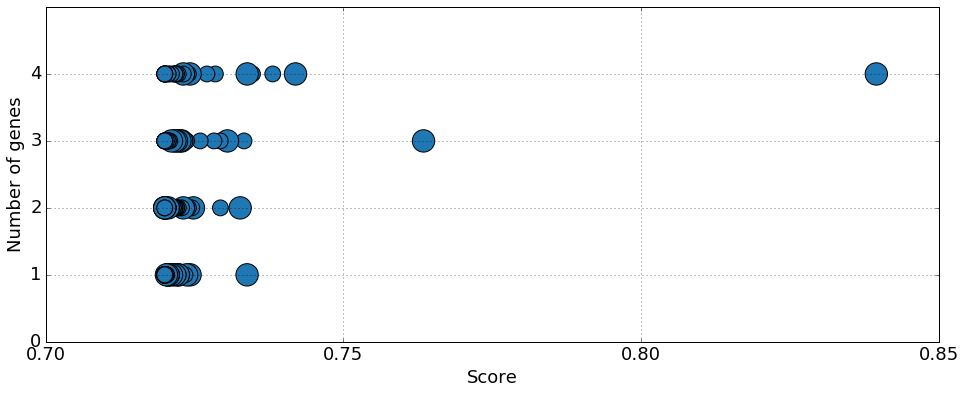

In [335]:
# Generate colors for graphs
colorseq = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
            '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
            '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
            '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

plt.rc('font', size='18')


fig, ax = plt.subplots(1, figsize=(16,6))
ax.scatter(xx,yy, c=colorseq[0], s=areas, alpha=1)
ax.yaxis.set_ticks(np.arange(0,5,1))
ax.set_ylim(0,5)
ax.xaxis.set_ticks(np.arange(0.7,0.9,0.05))
ax.set_xlim(0.7, 0.85)
ax.set_xlabel('Score')
ax.set_ylabel('Number of genes')
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.grid(True)

plt.show()

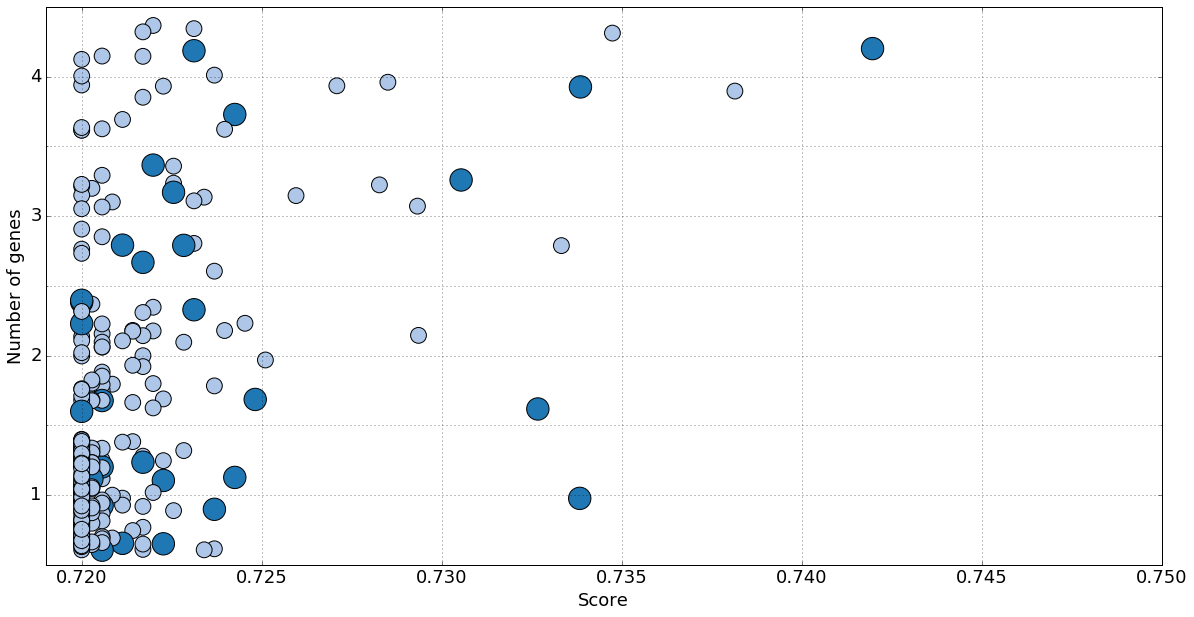

In [336]:
# Color code data points based on disease category

# Zoom in on clustered regions
ptsize = 250
areas = (areaidx*ptsize)+ptsize
colors = [colorseq[1-b] for b in incididx]


plt.rc('font', size='18')

# Scatter points for better readability
rndm = (np.random.random(yy.shape) - 0.5) * 0.8

fig, ax = plt.subplots(1, figsize=(20,10))
ax.scatter(xx,yy+rndm, c=colors, s=areas, alpha=1)
ax.yaxis.set_ticks(np.arange(0,5,1))
ax.set_ylim(0.5,4.5)
ax.xaxis.set_ticks(np.arange(0.7,0.81,0.005))
ax.set_xlim(0.719, 0.75)
ax.set_xlabel('Score')
ax.set_ylabel('Number of genes')
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.grid(True, which='both')

# ax.grid(color='k', linestyle='dotted', which='both', axis='both', linewidth=1)

plt.show()